In [1]:
%reset -f
from random import sample, choices
import itertools
import pandas as pd
import numpy as np
from utils import *
from wavhandler import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [2]:
filename = 'mosquitos.csv'
df = pd.read_csv(os.path.join(TEMP_DATADIR, filename), delimiter=';', index_col=0)

In [3]:
print(df.shape)
df.sample(3)

(279566, 16)


,fname,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,names,pathlen,fnamelen,temp,humd,label
101434,F170301_105922_039_G_050_T_25.2_H_51.1,0.153771,0.001028,0.000127,1148.437500,2298.828125,3447.265625,0.021259,0.011895,0.005666,/home/kalfasyan/data/insects/Wingbeats/Ae. alb...,9,9,25.2,51.1,Ae. albopictus
212333,F161220_191503_093_G_050,0.040789,0.009157,0.001568,392.578125,792.968750,1188.476562,0.034826,0.049261,0.017666,/home/kalfasyan/data/insects/Wingbeats/C. quin...,9,5,NaN,NaN,C. quinquefasciatus
161097,F170201_230126_093_G_050,0.139732,0.058833,0.010069,377.929688,747.070312,1094.726562,0.074935,0.035948,0.012935,/home/kalfasyan/data/insects/Wingbeats/An. ara...,9,5,NaN,NaN,An. arabiensis


In [4]:
# CREATING DATE COLUMN
df['date'] = df['fname'].apply(lambda x: pd.to_datetime(x.split('_')[0] + x.split('_')[1], format='F%y%m%d%H%M%S'))
df['date'] = df.date.dt.to_period('d').apply(lambda x: x.strftime('%Y%m%d'))
print(df.date.head(2))

0    20170209
1    20170209
Name: date, dtype: object


## Barplots of data signals collected per day

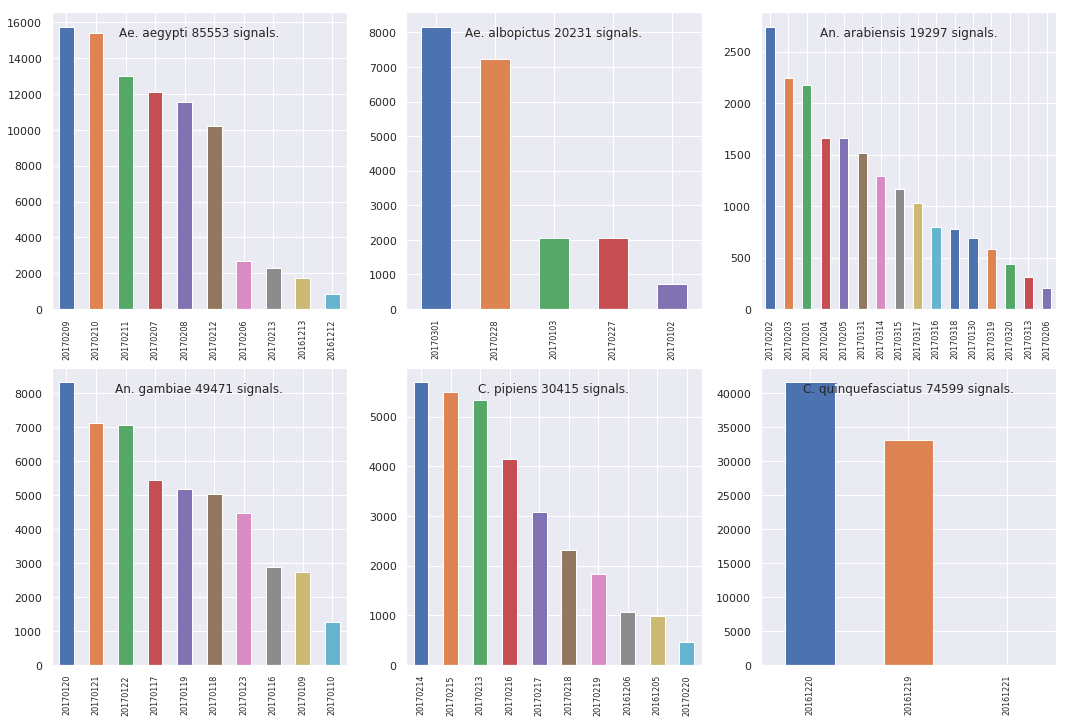

In [5]:
plt.figure(figsize=(18,12))
plt.tight_layout()
for q, (i, sub) in enumerate(df.groupby('label')):
    plt.subplot(2,3,q+1)
    plt.title(sub.label.unique()[0] +' '+ str(sub.shape[0])+' signals.', y=0.9)
    sub.date.value_counts().plot(kind='bar')
    plt.xticks(rotation=90, fontsize=8)

In [6]:
# for q, (i, sub) in enumerate(df.groupby('label')):
#     print(sub.date.value_counts())

## Random signal PSD example

100%|██████████| 2/2 [00:00<00:00, 837.10it/s]


Text(0.5, 0, 'Frequency (Hz)')

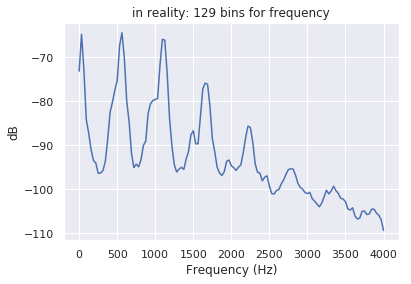

In [44]:
class_label = 'An. gambiae'
fs = 8000.
random_signal = read_simple(df[(df.label==class_label)].sample(2).names.tolist())[0]
plt.plot(np.linspace(0,fs/2,129), transform_data(random_signal.T)[0])
plt.title('in reality: 129 bins for frequency')
plt.ylabel('dB'); plt.xlabel('Frequency (Hz)')

## Distance matrix

100%|██████████| 1000/1000 [00:00<00:00, 1812.66it/s]


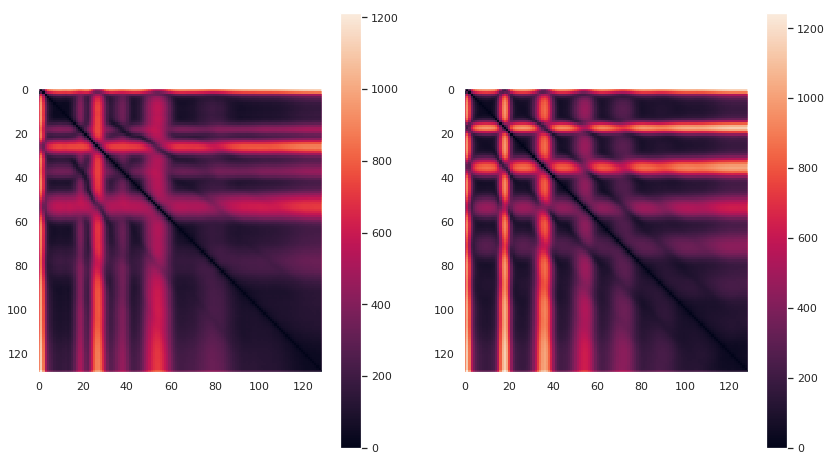

In [39]:
def get_data_for_day(selected_day=None, df=None, samples=None):
    X_names = df[(df.label==class_label) & (df.date == selected_day)].names
    if samples:
     X_names = sample(X_names.tolist(), samples)
    X_data = read_simple(X_names)[0].T
    X = transform_data(X_data)
    y = [selected_day for i in range(X.shape[0])]
    return X, y

def upper_triangular(a, metric='cosine'):
    from scipy.spatial.distance import pdist, squareform
    dist_mat = squareform(pdist(a.T, metric=metric))
    up_tr = dist_mat[np.triu_indices(len(dist_mat))]
    return up_tr, dist_mat

day = '20170123'
vsday = '20170109'
Xa, ya = get_data_for_day(selected_day=day, df=df[df.label==class_label], samples=1000)
Xb, yb = get_data_for_day(selected_day=vsday, df=df[df.label==class_label], samples=1000)
plt.figure(figsize=(14,8)); plt.tight_layout();
plt.subplot(1,2,1)
plt.imshow(upper_triangular(Xa, metric='euclidean')[1])
plt.colorbar()
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(upper_triangular(Xb, metric='euclidean')[1])
plt.colorbar()
plt.grid(False)

# Analysis

In [9]:
class_label = 'An. gambiae'
periods = df[df.label==class_label].date.value_counts().index.tolist()
periods = [periods[i] for i in range(len(periods))]
print('Periods for class \"{}\": \t{}'.format(class_label, periods))
print()
pair_combs = []
for i in itertools.combinations_with_replacement(periods, r=2):
    pair_combs.append(i)
print('Example combinations for periods of class \"{}\": \t{}'.format(class_label, pair_combs[:3]))
print('Total nr. of combinations: \t{}'.format(len(pair_combs)))

Periods for class "An. gambiae": 	['20170120', '20170121', '20170122', '20170117', '20170119', '20170118', '20170123', '20170116', '20170109', '20170110']

Example combinations for periods of class "An. gambiae": 	[('20170120', '20170120'), ('20170120', '20170121'), ('20170120', '20170122')]
Total nr. of combinations: 	55


In [10]:
alldf = []
for i in range(len(periods)):
    X, y = get_data_for_day(selected_day=periods[i], df=df[df.label==class_label], samples=None)
    tmp = pd.DataFrame(X)
    tmp['label'] = pd.Series(y)
    alldf.append(tmp)
df_all = pd.concat(alldf)

100%|██████████| 1262/1262 [00:00<00:00, 1575.89it/s]


In [11]:
iters = 100
corrs = {}
for p, pair in enumerate(pair_combs):
#     if p == 0:
#         break
    print(p/len(pair_combs)*100.)
    
    X1 = df_all[df_all.label==pair[0]].iloc[:,:-1].sample(1000).values
    X2 = df_all[df_all.label==pair[1]].iloc[:,:-1].sample(1000).values
    samplesize = np.min([X1.shape[0], X2.shape[0]])

    # BOOTSTRAP
    corrs[pair] = []
    for it in range(iters):
        # Sampling with replacement the data of the days - for as many times as "iters"
        bootstrap_sample1 = choices(list(range(0,samplesize)), k=samplesize)
        bootstrap_sample2 = choices(list(range(0,samplesize)), k=samplesize)
        #np.random.randint(0,samplesize,size=samplesize)

        d1,_ = upper_triangular(X1[bootstrap_sample1,:])
        d2,_ = upper_triangular(X2[bootstrap_sample2,:])
        corrs[pair].append(np.corrcoef(d1,d2)[0,1])

0.0
1.8181818181818181
3.6363636363636362
5.454545454545454
7.2727272727272725
9.090909090909092
10.909090909090908
12.727272727272727
14.545454545454545
16.363636363636363
18.181818181818183
20.0
21.818181818181817
23.636363636363637
25.454545454545453
27.27272727272727
29.09090909090909
30.909090909090907
32.72727272727273
34.54545454545455
36.36363636363637
38.18181818181819
40.0
41.81818181818181
43.63636363636363
45.45454545454545
47.27272727272727
49.09090909090909
50.90909090909091
52.72727272727272
54.54545454545454
56.36363636363636
58.18181818181818
60.0
61.81818181818181
63.63636363636363
65.45454545454545
67.27272727272727
69.0909090909091
70.9090909090909
72.72727272727273
74.54545454545455
76.36363636363637
78.18181818181819
80.0
81.81818181818183
83.63636363636363
85.45454545454545
87.27272727272727
89.0909090909091
90.9090909090909
92.72727272727272
94.54545454545455
96.36363636363636
98.18181818181819


In [12]:
# def upper_triangular(a, metric='cosine'):
#     from scipy.spatial.distance import pdist, squareform
#     dist_mat = squareform(pdist(a.T, metric=metric))
#     up_tr = dist_mat[np.triu_indices(len(dist_mat))]
#     return up_tr, dist_mat

# def get_data_for_day(selected_day=None, df=None, samples=None):
#     X_names = df[(df.label==class_label) & (df.date == selected_day)].names
#     if samples:
#         X_names = sample(X_names.tolist(), samples)
#     X_data = read_simple(X_names)[0].T
#     X = transform_data(X_data)
#     y = [selected_day for i in range(X.shape[0])]
#     return X, y

# iters = 1000
# corrs = {}
# for p, pair in enumerate(pair_combs):
# #     if p == 0:
# #         break
#     print(p/len(pair_combs)*100.)
#     # Creating matrices for the two days of the pair.
#     # This returns the "transformed" signals i.e. PSDs
#     X1, _ = get_data_for_day(selected_day=pair[0], df=df[df.label==class_label], samples=1000)
#     X2, _ = get_data_for_day(selected_day=pair[1], df=df[df.label==class_label], samples=1000)
    
#     # BOOTSTRAP
#     corrs[pair] = []
#     for it in range(iters):
#         samplesize = np.min([X1.shape[0], X2.shape[0]])

#         # Sampling with replacement the data of the days - for as many times as "iters"
#         bootstrap_sample1 = choices(list(range(0,samplesize)), k=samplesize)
#         bootstrap_sample2 = choices(list(range(0,samplesize)), k=samplesize)
#         #np.random.randint(0,samplesize,size=samplesize)

#         d1,_ = upper_triangular(X1[bootstrap_sample1,:])
#         d2,_ = upper_triangular(X2[bootstrap_sample2,:])
#         corrs[pair].append(np.corrcoef(d1,d2)[0,1])


### 95% confidence interval for all pair combinations

In [13]:
pd.concat([pd.DataFrame.from_dict(corrs, orient='index').T.quantile(0.025), pd.DataFrame.from_dict(corrs, orient='index').T.quantile(0.975)], axis=1).sort_values(by=0.025,ascending=False)

,0.025,0.975
"(20170109, 20170109)",0.994026,0.998387
"(20170119, 20170119)",0.993678,0.998044
"(20170110, 20170110)",0.992456,0.998049
"(20170118, 20170118)",0.991982,0.998299
"(20170120, 20170120)",0.991772,0.998023
"(20170117, 20170117)",0.990953,0.997760
"(20170119, 20170118)",0.986620,0.994831
"(20170121, 20170121)",0.986522,0.996301
"(20170116, 20170116)",0.985036,0.996770
"(20170122, 20170122)",0.984836,0.997977


### Median (quantile:0.5)

In [14]:
pd.DataFrame.from_dict(corrs, orient='index').T.median().sort_values(ascending=False) # quantile(0.5)

(20170109, 20170109)    0.997160
(20170119, 20170119)    0.996661
(20170110, 20170110)    0.996385
(20170118, 20170118)    0.996172
(20170120, 20170120)    0.996105
(20170117, 20170117)    0.995299
(20170122, 20170122)    0.994506
(20170116, 20170116)    0.993043
(20170121, 20170122)    0.993031
(20170121, 20170121)    0.992837
(20170123, 20170123)    0.992532
(20170119, 20170118)    0.991815
(20170117, 20170118)    0.985501
(20170109, 20170110)    0.981854
(20170120, 20170122)    0.981693
(20170121, 20170123)    0.980453
(20170120, 20170121)    0.980067
(20170117, 20170119)    0.979165
(20170122, 20170123)    0.974057
(20170120, 20170119)    0.950512
(20170120, 20170123)    0.940528
(20170120, 20170118)    0.929381
(20170121, 20170119)    0.928229
(20170122, 20170119)    0.910698
(20170121, 20170118)    0.898618
(20170120, 20170117)    0.898487
(20170122, 20170118)    0.893964
(20170122, 20170117)    0.877872
(20170121, 20170117)    0.876365
(20170119, 20170123)    0.839887
(20170118,

### Median correlation of each day with the rest

      stats   periods
0  0.934954  20170120
1  0.913423  20170121
2  0.902331  20170122


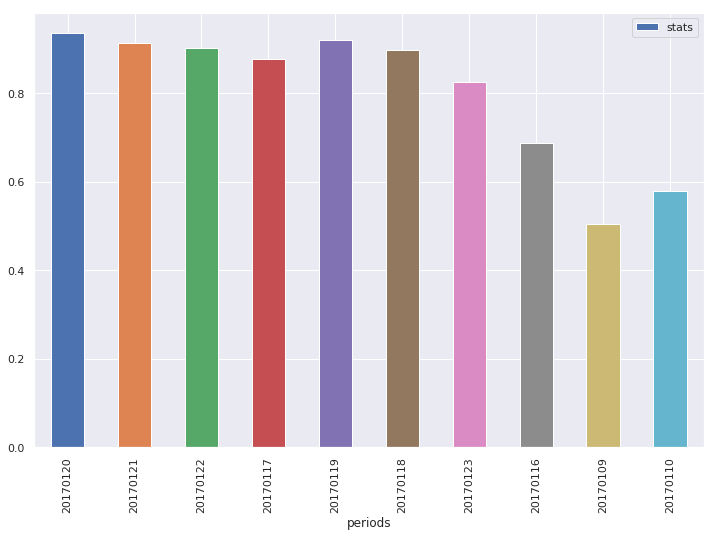

In [15]:
def get_period_stat(p):
    stats = {}
    for i in pair_combs:
        if periods[p] in i:
            stats[i] = np.median(corrs[i])
    return stats
df_periodstats = pd.DataFrame([(np.median(list(get_period_stat(i).values())), periods[i]) for i in range(len(periods))], columns=['stats','periods'])
print(df_periodstats.head(3))
df_periodstats.plot.bar(x='periods',y='stats', figsize=(12,8))

### Why are some days so poorly correlated with others?

In [45]:
day = '20170123'
vsday = '20170110'
Xa, ya = get_data_for_day(selected_day=day, df=df[df.label==class_label], samples=1000)
Xb, yb = get_data_for_day(selected_day=vsday, df=df[df.label==class_label], samples=1000)
print("There are {} signals for day {}".format(df[(df.label==class_label) & (df.date==day)].shape[0], day))
print("{0:.2f}% of the signals belong to that day".format(df[(df.label==class_label) & (df.date==day)].shape[0]/df[df.label==class_label].shape[0]*100.))
print("There are {} signals for day {}".format(df[(df.label==class_label) & (df.date==vsday)].shape[0], vsday))
print("{0:.2f}% of the signals belong to that day".format(df[(df.label==class_label) & (df.date==vsday)].shape[0]/df[df.label==class_label].shape[0]*100.))

print("In class {}, there are in total {} signals".format(class_label, df[df.label==class_label].shape[0]))

100%|██████████| 1000/1000 [00:00<00:00, 1556.40it/s]


There are 4474 signals for day 20170123
9.04% of the signals belong to that day
There are 1262 signals for day 20170110
2.55% of the signals belong to that day
In class An. gambiae, there are in total 49471 signals


### Distance matrix for that day

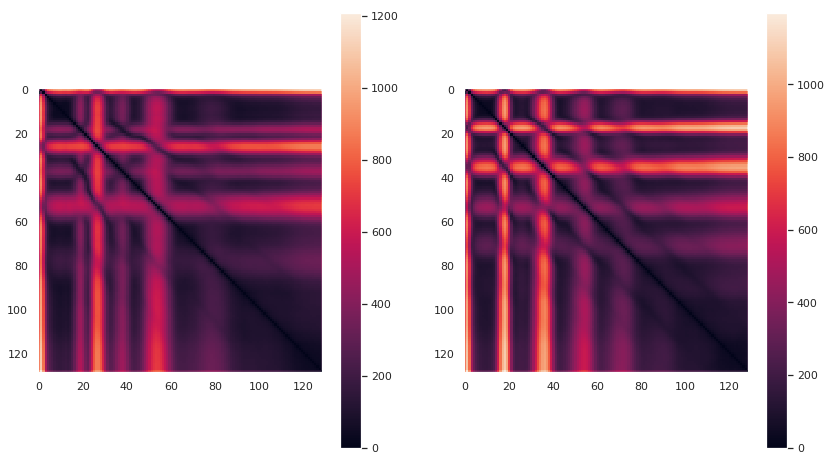

In [46]:
plt.figure(figsize=(14,8)); plt.tight_layout();
plt.subplot(1,2,1)
plt.imshow(upper_triangular(Xa, metric='euclidean')[1])
plt.colorbar()
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(upper_triangular(Xb, metric='euclidean')[1])
plt.colorbar()
plt.grid(False)

### Histograms of 'fr0' for selected day vs another day

(0, 3600)

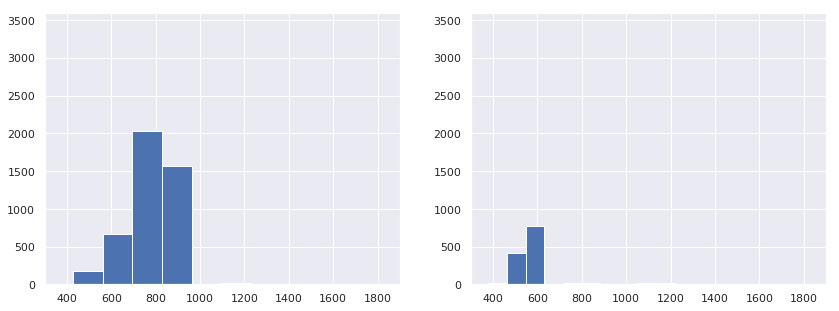

In [47]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
df[(df.label==class_label) & (df.date==day)].fr0.hist()
plt.xlim(300,1900)
plt.ylim(0,3600)
plt.subplot(1,2,2)
df[(df.label==class_label) & (df.date==vsday)].fr0.hist()
plt.xlim(300,1900)
plt.ylim(0,3600)

### Maybe the temperature/humidity measurements are different across days

In [48]:
for i, sub in df[df.label==class_label].groupby('date'):
    print('Day: {} , \nvalue counts:\n{}\n'.format(i,sub.temp.value_counts()))
    

Day: 20170109 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170110 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170116 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170117 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170118 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170119 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170120 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170121 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170122 , 
value counts:
Series([], Name: temp, dtype: int64)

Day: 20170123 , 
value counts:
Series([], Name: temp, dtype: int64)



### PCA on matrices of PSDs of compared days

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def perform_pca_on_matrix(X, y, daily_data=True):
#     idx = np.random.randint(X.shape[0], size=3000)
#     X = X[idx,:]
#     labelarray = y[idx]
    X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data
    if daily_data:
        y = pd.Series(y).apply(lambda x: periods.index(x))
    ncomps = 2
    pca = PCA(n_components=ncomps) # 10 to get 80% explained variance
    Χ_final = pca.fit_transform(X_std)
    print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )

    sns.scatterplot(Χ_final[:,0], Χ_final[:,1], alpha=0.6, hue=y, legend='full')
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    
    df_pca = pd.DataFrame(pca.components_,index = ['PC-1','PC-2'])#, 'PC-3'])
    return df_pca

In [21]:
df.label.unique()

array(['Ae. aegypti', 'Ae. albopictus', 'An. gambiae', 'An. arabiensis',
       'C. pipiens', 'C. quinquefasciatus'], dtype=object)

In [22]:
class_label = 'An. gambiae'
periods = df[df.label==class_label].date.value_counts().index.tolist()
periods = [periods[i] for i in range(len(periods))]
print('Periods for class \"{}\": \t{}'.format(class_label, periods))

def get_data_for_day(selected_day=None, df=None, samples=100):
    X_names = df[(df.label==class_label) & (df.date == selected_day)].names
    X_data = read_simple(sample(X_names.tolist(), samples))[0].T
#     X_data = read_simple(X_names)[0].T
    X = transform_data(X_data)
    y = [selected_day for i in range(X.shape[0])]
    return X, y

alldf = []
for i in range(len(periods)):
    X, y = get_data_for_day(selected_day=periods[i], df=df[df.label==class_label], samples=1000)
    tmp = pd.DataFrame(X)
    tmp['label'] = pd.Series(y)
    alldf.append(tmp)


  0%|          | 0/1000 [00:00<?, ?it/s]

Periods for class "An. gambiae": 	['20170120', '20170121', '20170122', '20170117', '20170119', '20170118', '20170123', '20170116', '20170109', '20170110']


100%|██████████| 1000/1000 [00:00<00:00, 1820.26it/s]


In [23]:
df_all = pd.concat(alldf)

EXPLAINED VARIANCE with 2 components: 0.54


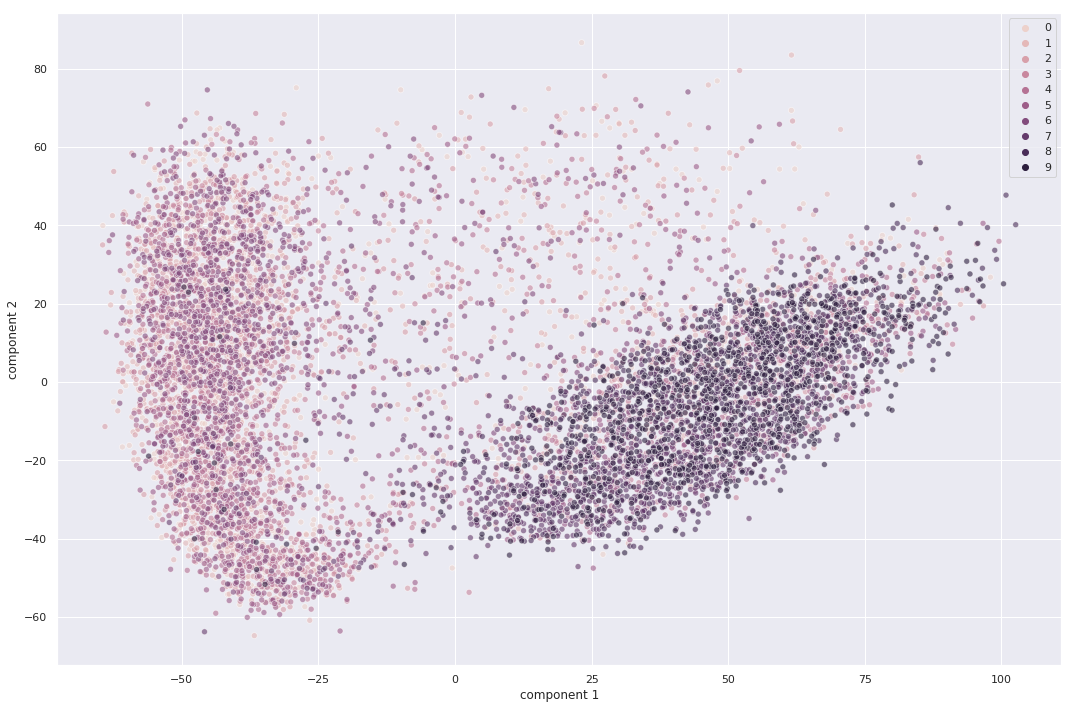

In [24]:
plt.figure(figsize=(18,12))
df_tmp = df_all#[df_all.label == periods[6]]
df_pca = perform_pca_on_matrix(df_tmp.iloc[:,:-1].values, df_tmp.label.values)

(-0.5, 0.5)

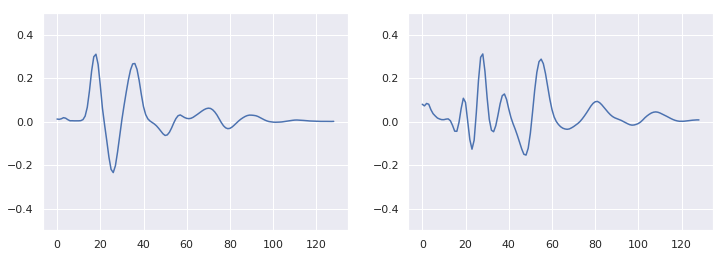

In [25]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1);df_pca.T['PC-1'].plot(); plt.ylim(-.5, .5)
plt.subplot(1,2,2);df_pca.T['PC-2'].plot(); plt.ylim(-.5,.5)

### For all data

In [26]:
df.label.unique().tolist()

['Ae. aegypti',
 'Ae. albopictus',
 'An. gambiae',
 'An. arabiensis',
 'C. pipiens',
 'C. quinquefasciatus']

In [27]:
class_label = 'An. gambiae'
X_names = df[df.label==class_label].names
X_data, y = read_simple(X_names.tolist())

In [28]:
X_data = transform_data(X_data.T)

100%|██████████| 49471/49471 [00:27<00:00, 1786.20it/s]


In [29]:
pd.Series(y).iloc[0]

'/home/kalfasyan/data/insects/Wingbeats/An. gambiae/Anopheles gambiae_15d-17d/D_17_01_10_11_38_30/F170110_114917_091_G_050.wav'

EXPLAINED VARIANCE with 2 components: 0.55


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
PC-1,0.013359,0.011504,0.015267,0.021847,0.019528,0.012450,0.007456,0.006845,0.005935,0.005812,...,0.003465,0.002839,0.002558,0.002258,0.002051,0.001779,0.001674,0.001588,0.001523,0.001608
PC-2,0.071526,0.063954,0.074699,0.070516,0.047554,0.031273,0.021680,0.013268,0.009038,0.007091,...,-0.001299,-0.001976,-0.001815,-0.001451,-0.000944,-0.000262,0.000400,0.000934,0.001206,0.001209


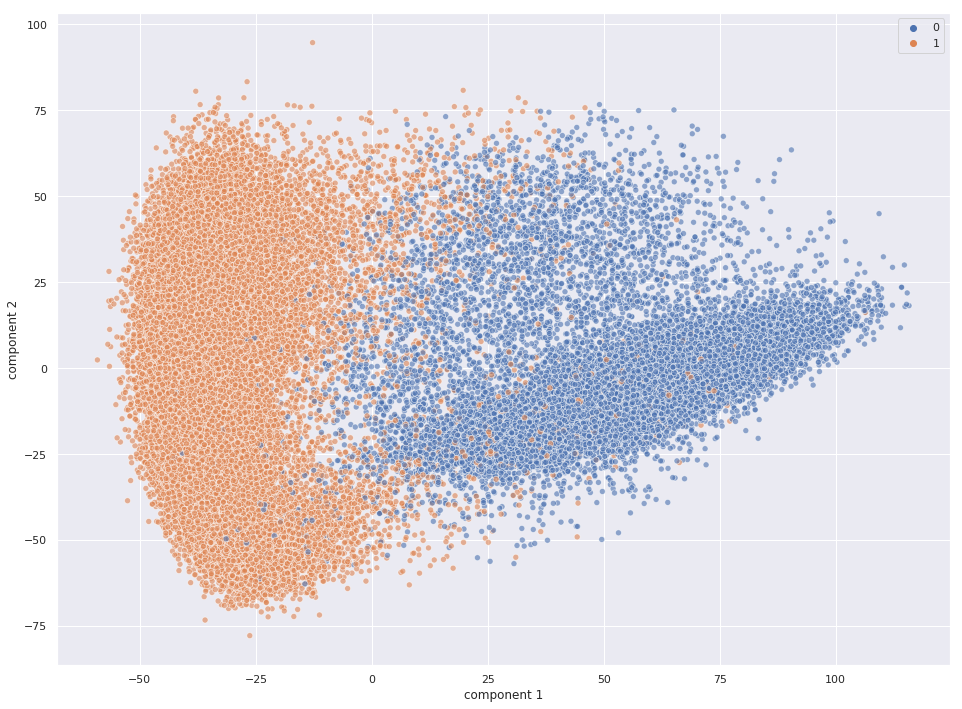

In [30]:
plt.figure(figsize=(16,12))


from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
transfomed_label = encoder.fit_transform((df[df.label==class_label].fr0 > 650).tolist())


tmpy = transfomed_label#pd.Series(y).apply(lambda x: x.split('/')[6])
perform_pca_on_matrix(X_data, tmpy, daily_data=False)

## Histograms of fr0 for all days

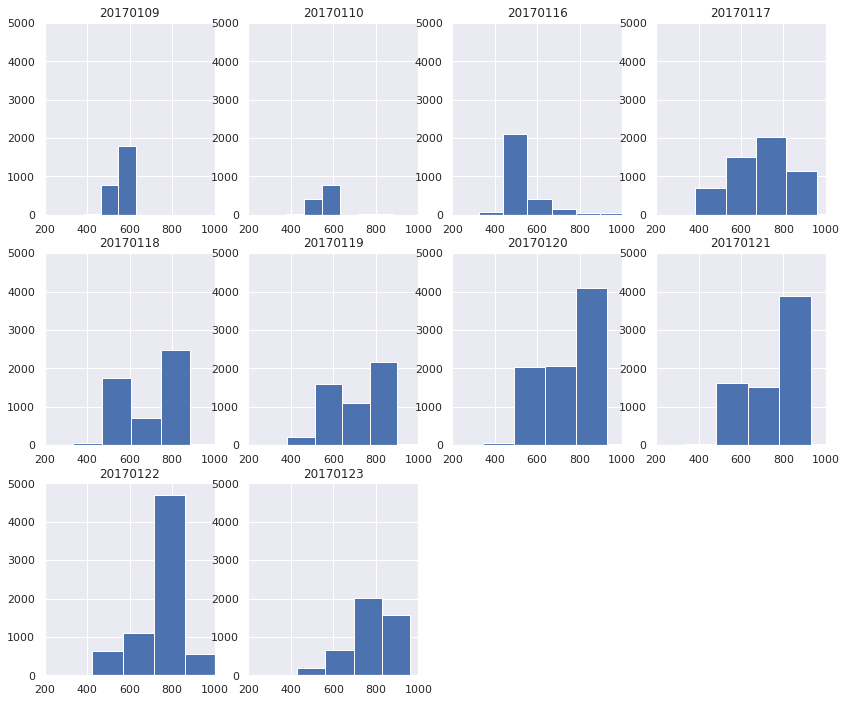

In [51]:
plt.figure(figsize=(14,12))
plt.tight_layout()
for i, (day, sub) in enumerate(df[df.label==class_label].groupby('date')):
    plt.subplot(3,4,i+1)
    plt.title(day)
    sub.fr0.hist(bins=10)
    plt.xlim(200, 1000)
    plt.ylim(0,5000)

#  
#  

## scrap notes

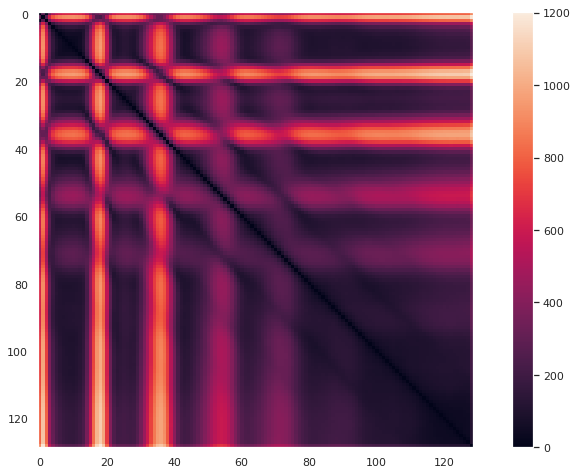

In [31]:
plt.figure(figsize=(14,8))
plt.imshow(upper_triangular(X2, metric='euclidean')[1])
plt.colorbar()
plt.grid(False)

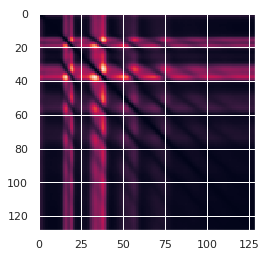

In [32]:
plt.imshow(upper_triangular(X1, metric='cosine')[1])

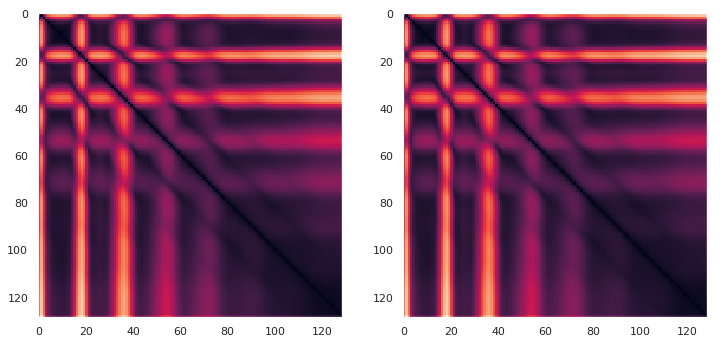

In [33]:
from scipy.spatial.distance import pdist, squareform
D1 = squareform(pdist(X1.T, metric='euclidean'))
D2 = squareform(pdist(X2.T, metric='euclidean'))
plt.figure(figsize=(12,8))
plt.subplot(1,2,1); plt.imshow(D1); plt.grid(False)
plt.subplot(1,2,2); plt.imshow(D2); plt.grid(False)

In [34]:
np.corrcoef(D1[np.triu_indices(len(D1))],
            D2[np.triu_indices(len(D2))])

array([[1.       , 0.9998617],
       [0.9998617, 1.       ]])

In [35]:
# df_x1 = pd.DataFrame(X1.T).describe()
# df_x2 = pd.DataFrame(X2.T).describe()

In [36]:
# X = np.vstack((X1,X2))
# y = np.vstack((y1.reshape(-1,1),y2.reshape(-1,1))).ravel()

# X, y = shuffle(X, y, random_state=3)

# from imblearn.under_sampling import RandomUnderSampler
# ros = RandomUnderSampler(random_state=0)
# ros.fit(X,y)
# X, y = ros.fit_resample(X,y)
# print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# from sklearn.tree import DecisionTreeClassifier
# classifier = DecisionTreeClassifier(random_state=0)
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)

# ac = accuracy_score(y_test, y_pred)
# #cv_ac = cross_val_score(classifier, X, y, cv=3, scoring='accuracy')
# print("ac: %f" % ac)
# #print("Name: %s, cv_ac: %f" % ('...', np.mean(cv_ac)))

In [37]:
# feature_importances = pd.DataFrame(classifier.feature_importances_,
#                                     columns=['importance']).sort_values('importance', ascending=False)
# feature_importances.head(10)